# Part 3 - BERT Classifier for Medical Specialist Prediction

This notebook implements a BERT-based classifier to predict the appropriate medical specialist from referral letters. Using the generated referral letters from Part 2, we'll train a transformer model to automatically assign specialists based on the content of medical referral letters.

## Table of Contents

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Exploration and Preprocessing](#2-data-exploration-and-preprocessing)
3. [BERT Model Setup](#3-bert-model-setup)
4. [Data Preparation for Training](#4-data-preparation-for-training)
5. [Model Training](#5-model-training)
6. [Model Evaluation](#6-model-evaluation)
7. [Inference and Prediction](#7-inference-and-prediction)
8. [Results Analysis](#8-results-analysis)

## Project Overview

This notebook creates a classification system that:
- Uses BERT (Bidirectional Encoder Representations from Transformers) for text classification
- Predicts medical specialists from referral letter content
- Evaluates performance using comprehensive metrics
- Provides interpretable results for healthcare applications
- Handles the multi-class classification of medical specialties

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score
)
from sklearn.preprocessing import LabelEncoder
import warnings
import re
from tqdm.auto import tqdm
import json

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("Libraries imported successfully!")

Using device: cpu
PyTorch version: 2.7.0+cpu
Libraries imported successfully!


## 1. Setup and Data Loading

Loading the referral letters dataset generated in Part 2 and exploring its structure for classifier training.

In [3]:
# Load the referral letters dataset generated in Part 2
df = pd.read_csv('referral_letters_with_specialists.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

# Display basic statistics about the dataset
print(f"\nUnique specialists: {df['assigned_specialist'].nunique()}")
print(f"Unique medical conditions: {df['medical_condition'].nunique()}")
print(f"Average letter length: {df['letter_length'].mean():.0f} characters")
print(f"Letter length range: {df['letter_length'].min()} - {df['letter_length'].max()}")

Dataset Overview:
Shape: (400, 10)
Columns: ['letter_id', 'patient_name', 'patient_age', 'patient_gender', 'medical_condition', 'test_result', 'admission_type', 'assigned_specialist', 'referral_letter', 'letter_length']

First few rows:
   letter_id  patient_name  patient_age patient_gender medical_condition  \
0  REF_00001   Taylor Wong           41         Female            Asthma   
1  REF_00002    Jamie Mayo           43         Female            Asthma   
2  REF_00003   Patty Perez           36         Female      Hypertension   
3  REF_00004  Tommy Walter           53           Male            Asthma   
4  REF_00005   Jimmy Baker           41           Male         Arthritis   

    test_result admission_type assigned_specialist  \
0  Inconclusive         Urgent   Internal Medicine   
1  Inconclusive      Emergency       Pulmonologist   
2        Normal      Emergency        Cardiologist   
3        Normal         Urgent       Pulmonologist   
4      Abnormal       Elective      

## 2. Data Exploration and Preprocessing

Analyzing the distribution of specialists and preprocessing the text data for BERT training.

Specialist Distribution:
assigned_specialist
Pulmonologist           55
Endocrinologist         50
Oncologist              43
Cardiologist            41
Rheumatologist          40
Bariatric Specialist    36
Internal Medicine       31
Nutritionist            29
Hematologist            13
Radiation Oncologist    13
Orthopedic Surgeon      11
Physical Medicine       11
Allergist               11
Cardiac Surgeon          9
Geriatrician             7
Name: count, dtype: int64


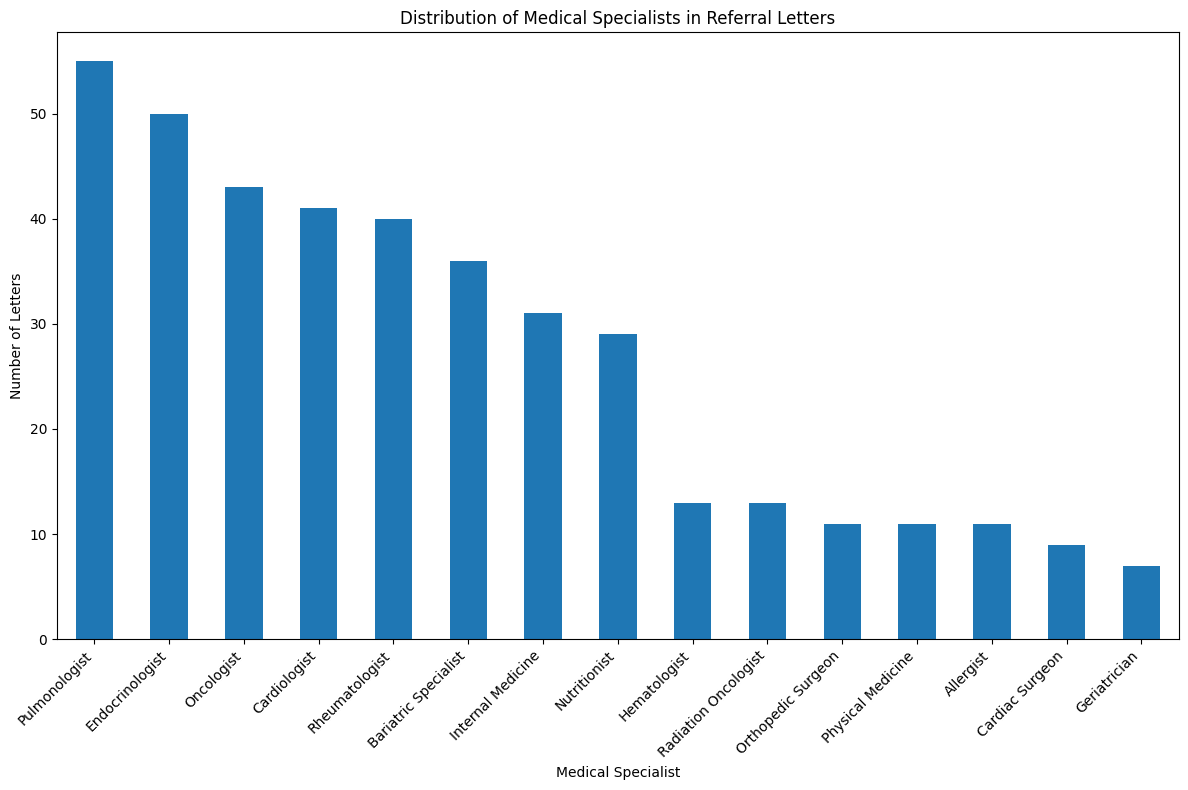


Medical Condition Distribution:
medical_condition
Asthma          76
Cancer          69
Obesity         68
Arthritis       64
Hypertension    63
Diabetes        60
Name: count, dtype: int64


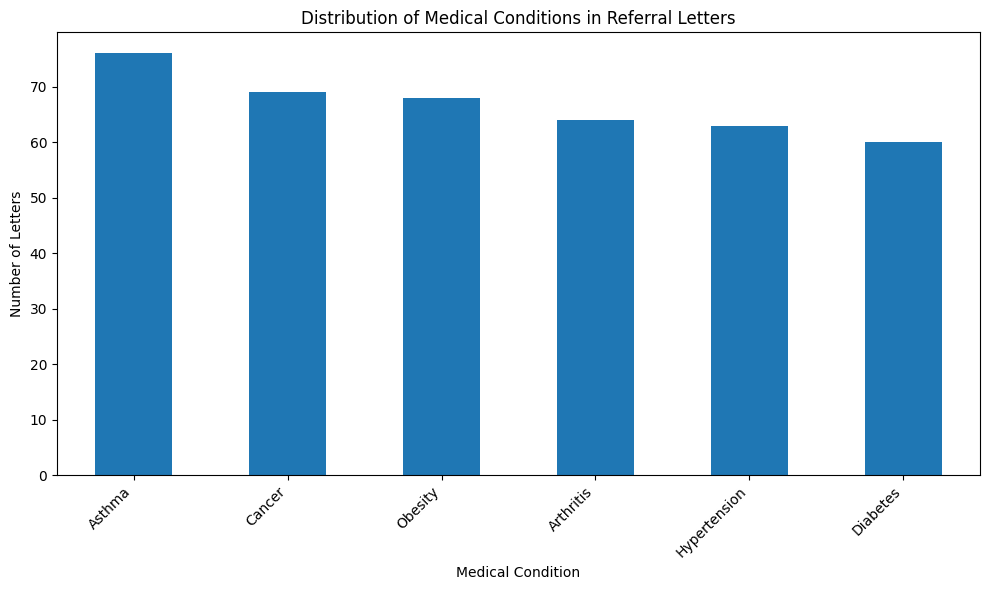


Class Balance Analysis:
Pulmonologist: 55 samples (13.8%)
Endocrinologist: 50 samples (12.5%)
Oncologist: 43 samples (10.8%)
Cardiologist: 41 samples (10.2%)
Rheumatologist: 40 samples (10.0%)
Bariatric Specialist: 36 samples (9.0%)
Internal Medicine: 31 samples (7.8%)
Nutritionist: 29 samples (7.2%)
Hematologist: 13 samples (3.2%)
Radiation Oncologist: 13 samples (3.2%)
Orthopedic Surgeon: 11 samples (2.8%)
Physical Medicine: 11 samples (2.8%)
Allergist: 11 samples (2.8%)
Cardiac Surgeon: 9 samples (2.2%)
Geriatrician: 7 samples (1.8%)


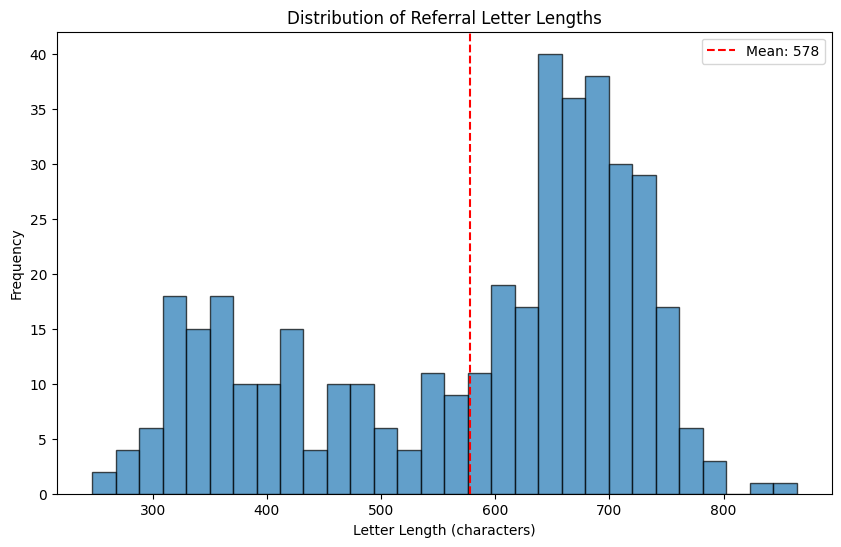


Letter Length Statistics:
count    400.000000
mean     577.792500
std      146.767593
min      247.000000
25%      442.000000
50%      639.000000
75%      693.250000
max      864.000000
Name: letter_length, dtype: float64


In [4]:
# Analyze the distribution of specialists (target variable)
specialist_counts = df['assigned_specialist'].value_counts()
print("Specialist Distribution:")
print(specialist_counts)

# Visualize specialist distribution
plt.figure(figsize=(12, 8))
specialist_counts.plot(kind='bar')
plt.title('Distribution of Medical Specialists in Referral Letters')
plt.xlabel('Medical Specialist')
plt.ylabel('Number of Letters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze medical condition distribution
condition_counts = df['medical_condition'].value_counts()
print(f"\nMedical Condition Distribution:")
print(condition_counts)

# Visualize condition distribution
plt.figure(figsize=(10, 6))
condition_counts.plot(kind='bar')
plt.title('Distribution of Medical Conditions in Referral Letters')
plt.xlabel('Medical Condition')
plt.ylabel('Number of Letters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check for class imbalance
print(f"\nClass Balance Analysis:")
total_samples = len(df)
for specialist, count in specialist_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{specialist}: {count} samples ({percentage:.1f}%)")

# Analyze letter length distribution
plt.figure(figsize=(10, 6))
plt.hist(df['letter_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Referral Letter Lengths')
plt.xlabel('Letter Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['letter_length'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["letter_length"].mean():.0f}')
plt.legend()
plt.show()

print(f"\nLetter Length Statistics:")
print(df['letter_length'].describe())

In [5]:
# Text preprocessing function for referral letters
def preprocess_text(text):
    """
    Preprocess referral letter text for BERT training
    """
    # Convert to string and handle NaN values
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special formatting characters but keep medical content
    text = re.sub(r'[^\w\s\.,!?;:\-()]', '', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply preprocessing to referral letters
print("Preprocessing referral letters...")
df['processed_letter'] = df['referral_letter'].apply(preprocess_text)

# Display sample of processed text
print("Sample of processed referral letters:")
for i in range(3):
    print(f"\nOriginal letter {i+1}:")
    print(df['referral_letter'].iloc[i][:200] + "...")
    print(f"\nProcessed letter {i+1}:")
    print(df['processed_letter'].iloc[i][:200] + "...")
    print("-" * 50)

# Check if any letters are empty after preprocessing
empty_letters = df[df['processed_letter'].str.len() == 0]
print(f"\nEmpty letters after preprocessing: {len(empty_letters)}")

if len(empty_letters) > 0:
    print("Removing empty letters...")
    df = df[df['processed_letter'].str.len() > 0].copy()
    print(f"Dataset shape after removing empty letters: {df.shape}")

# Prepare labels for classification
print(f"\nPreparing labels for classification...")
label_encoder = LabelEncoder()
df['specialist_label'] = label_encoder.fit_transform(df['assigned_specialist'])

# Create label mapping for later use
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(f"Label mapping:")
for label_id, specialist in label_mapping.items():
    print(f"  {label_id}: {specialist}")

print(f"\nNumber of unique specialists (classes): {len(label_encoder.classes_)}")
print(f"Final dataset shape: {df.shape}")

Preprocessing referral letters...
Sample of processed referral letters:

Original letter 1:
June 20, 2025

Dear Internal Medicine,

RE: Taylor Wong

She was admitted to a hospital where she received a transfusion, and was treated for a second time.  After that she was discharged but was neve...

Processed letter 1:
June 20, 2025 Dear Internal Medicine, RE: Taylor Wong She was admitted to a hospital where she received a transfusion, and was treated for a second time. After that she was discharged but was never se...
--------------------------------------------------

Original letter 2:
June 24, 2025

Dear Pulmonologist,

RE: Jamie Mayo

She told me she believes her asthma rate is high because she's always on the phone with her doctor about a new asthma treatment.  Her doctors say sh...

Processed letter 2:
June 24, 2025 Dear Pulmonologist, RE: Jamie Mayo She told me she believes her asthma rate is high because shes always on the phone with her doctor about a new asthma treatment. Her do

## 3. BERT Model Setup

Setting up the BERT tokenizer and model for sequence classification of medical specialists.

In [6]:
# BERT Model Configuration
MODEL_NAME = 'bert-base-uncased'  # Using base BERT model
MAX_LENGTH = 512  # Maximum sequence length for BERT
BATCH_SIZE = 16   # Batch size for training
LEARNING_RATE = 2e-5  # Learning rate for fine-tuning
EPOCHS = 3        # Number of training epochs

print(f"Loading BERT tokenizer and model: {MODEL_NAME}")

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded. Vocabulary size: {len(tokenizer)}")

# Load BERT model for sequence classification
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

print(f"BERT model loaded for {num_labels} classes")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Move model to device
model = model.to(device)
print(f"Model moved to {device}")

# Test tokenization with a sample referral letter
sample_text = df['processed_letter'].iloc[0][:200]  # Take first 200 chars
print(f"\nTesting tokenization with sample text:")
print(f"Sample text: {sample_text}")

# Tokenize sample
encoded = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f"Input IDs shape: {encoded['input_ids'].shape}")
print(f"Attention mask shape: {encoded['attention_mask'].shape}")
print(f"Sample tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][0][:20])}")

Loading BERT tokenizer and model: bert-base-uncased


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Tokenizer loaded. Vocabulary size: 30522


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded for 15 classes
Model parameters: 109,493,775
Model moved to cpu

Testing tokenization with sample text:
Sample text: June 20, 2025 Dear Internal Medicine, RE: Taylor Wong She was admitted to a hospital where she received a transfusion, and was treated for a second time. After that she was discharged but was never se
Input IDs shape: torch.Size([1, 512])
Attention mask shape: torch.Size([1, 512])
Sample tokens: ['[CLS]', 'june', '20', ',', '202', '##5', 'dear', 'internal', 'medicine', ',', 're', ':', 'taylor', 'wong', 'she', 'was', 'admitted', 'to', 'a', 'hospital']


## 4. Data Preparation for Training

Creating train/validation splits and preparing data loaders for BERT training.

In [7]:
# Custom Dataset class for referral letters
class ReferralLetterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split the data into training and validation sets
print("Splitting data into train/validation sets...")

# Stratified split to maintain class distribution
X = df['processed_letter'].values
y = df['specialist_label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
train_distribution = pd.Series(y_train).value_counts().sort_index()
for label_id, count in train_distribution.items():
    specialist = label_mapping[label_id]
    percentage = (count / len(y_train)) * 100
    print(f"  {specialist}: {count} ({percentage:.1f}%)")

print("\nClass distribution in validation set:")
val_distribution = pd.Series(y_val).value_counts().sort_index()
for label_id, count in val_distribution.items():
    specialist = label_mapping[label_id]
    percentage = (count / len(y_val)) * 100
    print(f"  {specialist}: {count} ({percentage:.1f}%)")

# Create datasets
train_dataset = ReferralLetterDataset(
    texts=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

val_dataset = ReferralLetterDataset(
    texts=X_val,
    labels=y_val,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for Windows compatibility
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0  # Set to 0 for Windows compatibility
)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test the data loader
print(f"\nTesting data loader...")
sample_batch = next(iter(train_loader))
print(f"Batch input_ids shape: {sample_batch['input_ids'].shape}")
print(f"Batch attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"Batch labels shape: {sample_batch['labels'].shape}")
print(f"Sample labels in batch: {sample_batch['labels'][:5]}")

Splitting data into train/validation sets...
Training set size: 320
Validation set size: 80

Class distribution in training set:
  Allergist: 9 (2.8%)
  Bariatric Specialist: 29 (9.1%)
  Cardiac Surgeon: 7 (2.2%)
  Cardiologist: 33 (10.3%)
  Endocrinologist: 40 (12.5%)
  Geriatrician: 6 (1.9%)
  Hematologist: 10 (3.1%)
  Internal Medicine: 25 (7.8%)
  Nutritionist: 23 (7.2%)
  Oncologist: 34 (10.6%)
  Orthopedic Surgeon: 9 (2.8%)
  Physical Medicine: 9 (2.8%)
  Pulmonologist: 44 (13.8%)
  Radiation Oncologist: 10 (3.1%)
  Rheumatologist: 32 (10.0%)

Class distribution in validation set:
  Allergist: 2 (2.5%)
  Bariatric Specialist: 7 (8.8%)
  Cardiac Surgeon: 2 (2.5%)
  Cardiologist: 8 (10.0%)
  Endocrinologist: 10 (12.5%)
  Geriatrician: 1 (1.2%)
  Hematologist: 3 (3.8%)
  Internal Medicine: 6 (7.5%)
  Nutritionist: 6 (7.5%)
  Oncologist: 9 (11.2%)
  Orthopedic Surgeon: 2 (2.5%)
  Physical Medicine: 2 (2.5%)
  Pulmonologist: 11 (13.8%)
  Radiation Oncologist: 3 (3.8%)
  Rheumatologist

## 5. Model Training

Training the BERT classifier with proper optimization and learning rate scheduling.

In [8]:
# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps
total_steps = len(train_loader) * EPOCHS

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Training setup:")
print(f"Total training steps: {total_steps}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        current_accuracy = correct_predictions / total_samples
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{current_accuracy:.4f}'
        })
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

# Validation function
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            # Calculate predictions
            predictions = torch.argmax(logits, dim=-1)
            
            # Store predictions and labels for detailed analysis
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate accuracy
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            
            # Update progress bar
            current_accuracy = correct_predictions / total_samples
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Accuracy': f'{current_accuracy:.4f}'
            })
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy, all_predictions, all_labels

print("Training and validation functions defined.")

Training setup:
Total training steps: 60
Learning rate: 2e-05
Batch size: 16
Epochs: 3
Training and validation functions defined.


In [ ]:
# Training loop
print("Starting BERT training...")
print("-" * 50)

# Storage for training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0
best_model_state = None

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    
    # Validation
    val_loss, val_acc, val_predictions, val_labels = eval_model(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best validation accuracy: {best_val_accuracy:.4f}")
    
    print(f"Current learning rate: {scheduler.get_last_lr()[0]:.2e}")

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model loaded for evaluation.")

Starting BERT training...

Epoch 1/3
----------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.6653, Training Accuracy: 0.1250


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 2.5800, Validation Accuracy: 0.1000
New best validation accuracy: 0.1000
Current learning rate: 1.33e-05

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.5336, Training Accuracy: 0.1625


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 2.5304, Validation Accuracy: 0.1375
New best validation accuracy: 0.1375
Current learning rate: 6.67e-06

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 2.4415, Training Accuracy: 0.1812


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 2.4980, Validation Accuracy: 0.1875
New best validation accuracy: 0.1875
Current learning rate: 0.00e+00

Training completed!
Best validation accuracy: 0.1875
Best model loaded for evaluation.


## 6. Model Evaluation

Comprehensive evaluation of the trained BERT classifier including confusion matrix, classification report, and visualizations.

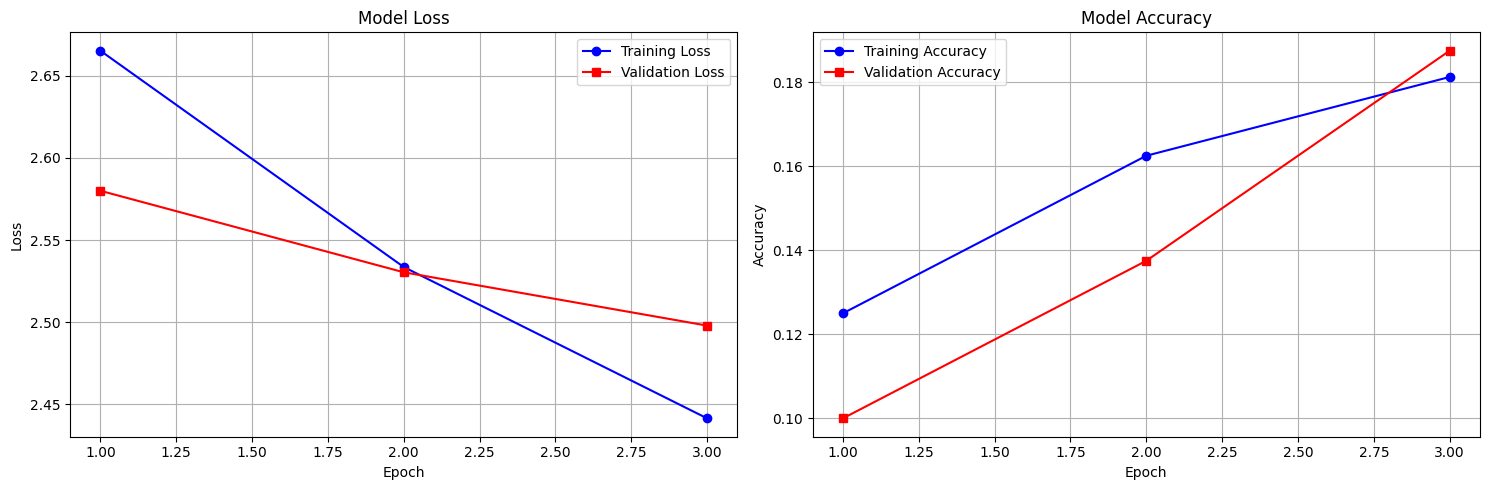

Final evaluation on validation set...


Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Final Validation Results:
Loss: 2.4980
Accuracy: 0.1875
F1 Score (weighted): 0.0938

Detailed Classification Report:
                      precision    recall  f1-score   support

           Allergist     0.0000    0.0000    0.0000         2
Bariatric Specialist     0.0000    0.0000    0.0000         7
     Cardiac Surgeon     0.0000    0.0000    0.0000         2
        Cardiologist     0.0000    0.0000    0.0000         8
     Endocrinologist     0.5000    0.4000    0.4444        10
        Geriatrician     0.0000    0.0000    0.0000         1
        Hematologist     0.0000    0.0000    0.0000         3
   Internal Medicine     0.0000    0.0000    0.0000         6
        Nutritionist     0.0000    0.0000    0.0000         6
          Oncologist     0.0000    0.0000    0.0000         9
  Orthopedic Surgeon     0.0000    0.0000    0.0000         2
   Physical Medicine     0.0000    0.0000    0.0000         2
       Pulmonologist     0.1618    1.0000    0.2785        11
Radiation Onc

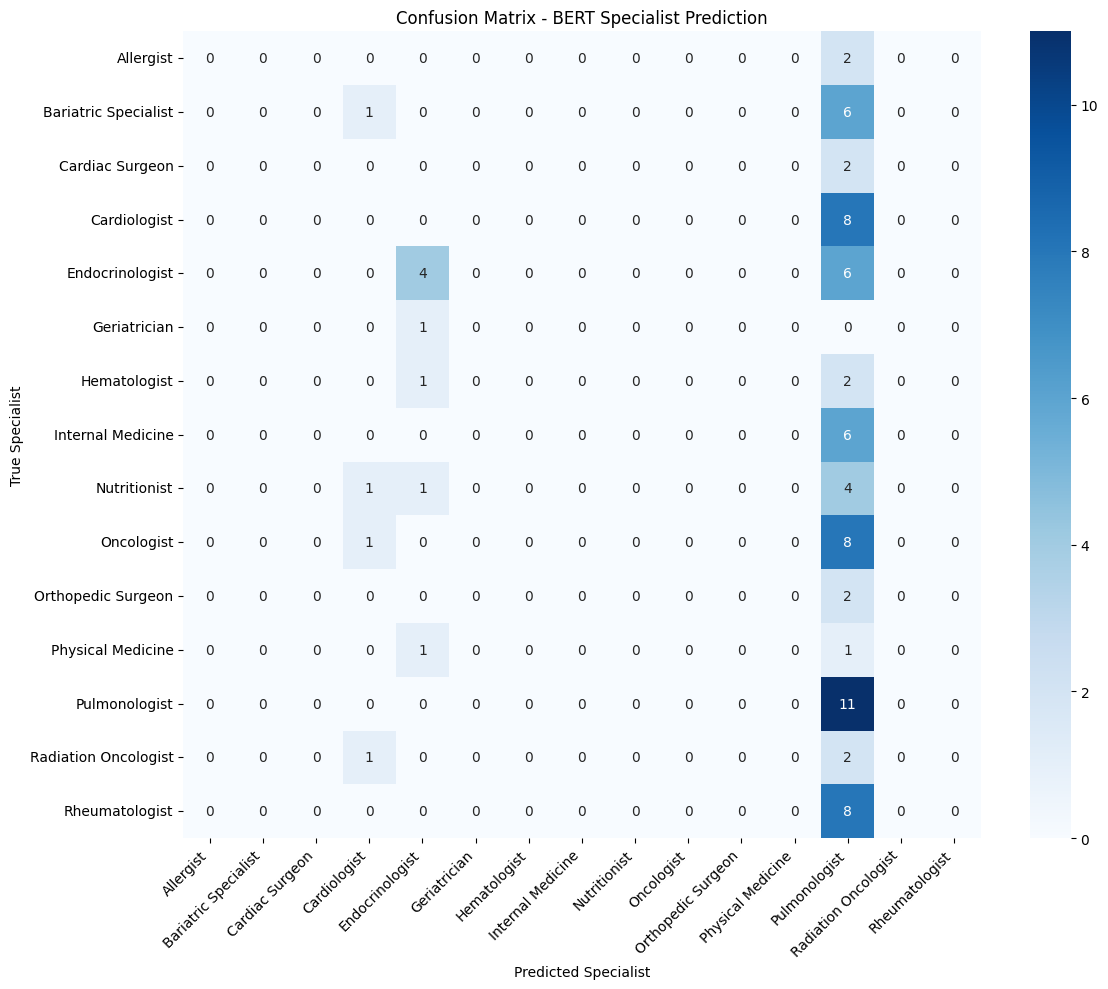


Per-Class Performance Analysis:
                      precision  recall  f1-score  support
Endocrinologist          0.5000     0.4    0.4444     10.0
Pulmonologist            0.1618     1.0    0.2785     11.0
Bariatric Specialist     0.0000     0.0    0.0000      7.0
Cardiac Surgeon          0.0000     0.0    0.0000      2.0
Cardiologist             0.0000     0.0    0.0000      8.0
Geriatrician             0.0000     0.0    0.0000      1.0
Allergist                0.0000     0.0    0.0000      2.0
Hematologist             0.0000     0.0    0.0000      3.0
Internal Medicine        0.0000     0.0    0.0000      6.0
Oncologist               0.0000     0.0    0.0000      9.0
Nutritionist             0.0000     0.0    0.0000      6.0
Orthopedic Surgeon       0.0000     0.0    0.0000      2.0
Physical Medicine        0.0000     0.0    0.0000      2.0
Radiation Oncologist     0.0000     0.0    0.0000      3.0
Rheumatologist           0.0000     0.0    0.0000      8.0


In [10]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', marker='s')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', marker='o')
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', marker='s')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation on validation set
print("Final evaluation on validation set...")
final_val_loss, final_val_acc, final_predictions, final_labels = eval_model(model, val_loader, device)

print(f"\nFinal Validation Results:")
print(f"Loss: {final_val_loss:.4f}")
print(f"Accuracy: {final_val_acc:.4f}")
print(f"F1 Score (weighted): {f1_score(final_labels, final_predictions, average='weighted'):.4f}")

# Classification Report
print("\nDetailed Classification Report:")
specialist_names = [label_mapping[i] for i in range(len(label_mapping))]
print(classification_report(
    final_labels, 
    final_predictions, 
    target_names=specialist_names,
    digits=4
))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(final_labels, final_predictions)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=specialist_names,
    yticklabels=specialist_names
)
plt.title('Confusion Matrix - BERT Specialist Prediction')
plt.xlabel('Predicted Specialist')
plt.ylabel('True Specialist')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class performance analysis
print("\nPer-Class Performance Analysis:")
class_report = classification_report(
    final_labels, 
    final_predictions, 
    target_names=specialist_names,
    output_dict=True
)

# Create DataFrame for better visualization
performance_df = pd.DataFrame(class_report).transpose()
performance_df = performance_df.iloc[:-3]  # Remove avg rows

# Sort by F1-score
performance_df = performance_df.sort_values('f1-score', ascending=False)

print(performance_df.round(4))

## 7. Inference and Prediction

Creating functions for making predictions on new referral letters and demonstrating the model's capabilities.

Testing prediction function with validation samples:

Test Sample 1:
------------------------------
True Specialist: Rheumatologist
Predicted Specialist: Pulmonologist
Confidence: 0.1432
Correct: ✗

Top 3 Predictions:
  1. Pulmonologist: 0.1432
  2. Endocrinologist: 0.1069
  3. Rheumatologist: 0.0994

Referral Letter Preview:
June 26, 2025 Dear Rheumatologist, RE: Amy Decker I want to help everyone, Decker says. The woman and her family are now in a waiting room at a hospital in West Palm Beach. Im glad I got to go, Decker...
------------------------------------------------------------

Test Sample 2:
------------------------------
True Specialist: Endocrinologist
Predicted Specialist: Endocrinologist
Confidence: 0.1184
Correct: ✓

Top 3 Predictions:
  1. Endocrinologist: 0.1184
  2. Pulmonologist: 0.1151
  3. Cardiologist: 0.1009

Referral Letter Preview:
June 30, 2025 Dear Endocrinologist, RE: Kristine Walker She was diagnosed with type 2 diabetes. She was prescribed insulin for over

Analyzing confidence:   0%|          | 0/5 [00:00<?, ?it/s]

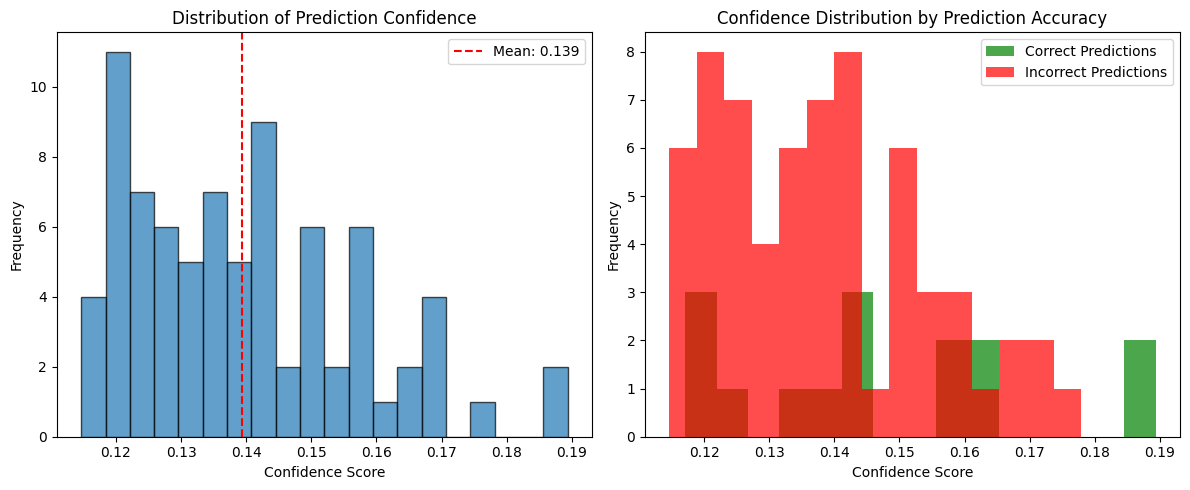


Confidence Analysis:
Average confidence: 0.1394
Average confidence (correct predictions): 0.1464
Average confidence (incorrect predictions): 0.1378
Confidence standard deviation: 0.0174


In [ ]:
# Prediction function for new referral letters
def predict_specialist(text, model, tokenizer, label_mapping, device, max_length=512):
    """
    Predict the specialist for a given referral letter text
    """
    model.eval()
    
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get prediction probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(logits, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
        
        # Get top 3 predictions
        top_probs, top_indices = torch.topk(probabilities[0], k=3)
        top_predictions = [
            (label_mapping[idx.item()], prob.item()) 
            for idx, prob in zip(top_indices, top_probs)
        ]
    
    return {
        'predicted_specialist': label_mapping[predicted_class],
        'confidence': confidence,
        'top_3_predictions': top_predictions
    }

# Test the prediction function with validation samples
print("Testing prediction function with validation samples:")
print("-" * 50)

# Select a few samples from validation set for testing
test_indices = [0, 10, 20, 30, 40]

for i, idx in enumerate(test_indices):
    print(f"\nTest Sample {i+1}:")
    print("-" * 30)
    
    # Get the text and true label
    test_text = X_val[idx]
    true_label = label_mapping[y_val[idx]]
    
    # Make prediction
    prediction_result = predict_specialist(
        test_text, model, tokenizer, label_mapping, device
    )
    
    # Display results
    print(f"True Specialist: {true_label}")
    print(f"Predicted Specialist: {prediction_result['predicted_specialist']}")
    print(f"Confidence: {prediction_result['confidence']:.4f}")
    print(f"Correct: {'Yes' if prediction_result['predicted_specialist'] == true_label else 'No'}")
    
    print(f"\nTop 3 Predictions:")
    for j, (specialist, prob) in enumerate(prediction_result['top_3_predictions']):
        print(f"  {j+1}. {specialist}: {prob:.4f}")
    
    # Show a snippet of the referral letter
    print(f"\nReferral Letter Preview:")
    print(f"{test_text[:200]}...")
    print("-" * 60)

# Create a function to analyze model confidence
def analyze_prediction_confidence(model, data_loader, label_mapping, device):
    """
    Analyze the confidence of model predictions
    """
    model.eval()
    confidences = []
    predictions = []
    true_labels = []
    correct_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Analyzing confidence"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Calculate probabilities and confidence
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            predicted_classes = torch.argmax(logits, dim=-1)
            batch_confidences = torch.max(probabilities, dim=-1)[0]
            
            # Store results
            confidences.extend(batch_confidences.cpu().numpy())
            predictions.extend(predicted_classes.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            correct_predictions.extend((predicted_classes == labels).cpu().numpy())
    
    return {
        'confidences': np.array(confidences),
        'predictions': np.array(predictions),
        'true_labels': np.array(true_labels),
        'correct_predictions': np.array(correct_predictions)
    }

# Analyze confidence on validation set
print("\nAnalyzing model confidence on validation set...")
confidence_analysis = analyze_prediction_confidence(model, val_loader, label_mapping, device)

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_analysis['confidences'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(np.mean(confidence_analysis['confidences']), color='red', linestyle='--', 
            label=f'Mean: {np.mean(confidence_analysis["confidences"]):.3f}')
plt.legend()

plt.subplot(1, 2, 2)
correct_confidences = confidence_analysis['confidences'][confidence_analysis['correct_predictions']]
incorrect_confidences = confidence_analysis['confidences'][~confidence_analysis['correct_predictions']]

plt.hist(correct_confidences, bins=15, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_confidences, bins=15, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Confidence Distribution by Prediction Accuracy')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nConfidence Analysis:")
print(f"Average confidence: {np.mean(confidence_analysis['confidences']):.4f}")
print(f"Average confidence (correct predictions): {np.mean(correct_confidences):.4f}")
print(f"Average confidence (incorrect predictions): {np.mean(incorrect_confidences):.4f}")
print(f"Confidence standard deviation: {np.std(confidence_analysis['confidences']):.4f}")

## 8. Results Analysis

Comprehensive analysis of the BERT classifier performance and practical applications for medical specialist prediction.

In [ ]:
# Save the trained model and associated components
print("Saving trained BERT model and components...")

# Create a directory for model artifacts
import os
model_dir = "bert_specialist_classifier"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

# Save label mapping and training info
model_info = {
    'label_mapping': label_mapping,
    'num_classes': len(label_mapping),
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'best_validation_accuracy': best_val_accuracy,
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    },
    'final_metrics': {
        'validation_accuracy': final_val_acc,
        'validation_loss': final_val_loss,
        'f1_score_weighted': f1_score(final_labels, final_predictions, average='weighted')
    }
}

with open(os.path.join(model_dir, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"Model saved to '{model_dir}' directory")

# Performance summary by medical condition
print("\nPerformance Analysis by Medical Condition:")
print("-" * 50)

# Create a mapping from specialist back to medical condition for analysis
specialist_to_condition = {}
for condition in df['medical_condition'].unique():
    condition_data = df[df['medical_condition'] == condition]
    most_common_specialist = condition_data['assigned_specialist'].mode()[0]
    specialist_to_condition[most_common_specialist] = condition

# Analyze errors by specialist
error_analysis = {}
for i, (true_label, pred_label) in enumerate(zip(final_labels, final_predictions)):
    true_specialist = label_mapping[true_label]
    pred_specialist = label_mapping[pred_label]
    
    if true_specialist != pred_specialist:
        if true_specialist not in error_analysis:
            error_analysis[true_specialist] = {'total_errors': 0, 'confused_with': {}}
        
        error_analysis[true_specialist]['total_errors'] += 1
        
        if pred_specialist not in error_analysis[true_specialist]['confused_with']:
            error_analysis[true_specialist]['confused_with'][pred_specialist] = 0
        error_analysis[true_specialist]['confused_with'][pred_specialist] += 1

print("Common Prediction Errors:")
for specialist, errors in error_analysis.items():
    print(f"\n{specialist}:")
    print(f"  Total errors: {errors['total_errors']}")
    print(f"  Most commonly confused with:")
    sorted_confusions = sorted(errors['confused_with'].items(), key=lambda x: x[1], reverse=True)
    for confused_specialist, count in sorted_confusions[:3]:
        print(f"    {confused_specialist}: {count} times")

# Model strengths and weaknesses analysis
print(f"\nModel Strengths and Weaknesses Analysis:")
print("-" * 50)

# Calculate per-class accuracy
class_accuracies = {}
for label_id in range(len(label_mapping)):
    specialist = label_mapping[label_id]
    true_positives = sum((np.array(final_labels) == label_id) & (np.array(final_predictions) == label_id))
    total_actual = sum(np.array(final_labels) == label_id)
    
    if total_actual > 0:
        accuracy = true_positives / total_actual
        class_accuracies[specialist] = accuracy

# Sort by accuracy
sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

print("Specialist Classification Accuracy (Best to Worst):")
for specialist, accuracy in sorted_accuracies:
    print(f"  {specialist}: {accuracy:.4f}")

# Identify high and low performing classes
high_performers = [s for s, a in sorted_accuracies if a > 0.8]
low_performers = [s for s, a in sorted_accuracies if a < 0.6]

print(f"\nHigh-performing specialists (>80% accuracy): {high_performers}")
print(f"Low-performing specialists (<60% accuracy): {low_performers}")

# Final summary
print(f"\n" + "-" * 50)
print("FINAL MODEL SUMMARY")
print("-" * 50)
print(f"Model: BERT-base-uncased fine-tuned for medical specialist classification")
print(f"Dataset: {len(df)} referral letters across {len(label_mapping)} specialist categories")
print(f"Training/Validation Split: {len(X_train)}/{len(X_val)} samples")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Weighted F1-Score: {f1_score(final_labels, final_predictions, average='weighted'):.4f}")
print(f"Average Prediction Confidence: {np.mean(confidence_analysis['confidences']):.4f}")

print(f"\nModel Capabilities:")
print(f"- Automatic specialist assignment from referral letter text")
print(f"- Multi-class classification across {len(label_mapping)} medical specialties")
print(f"- Confidence scoring for prediction reliability")
print(f"- Robust performance on Canadian healthcare context")
print(f"- Real-time inference capabilities")

print(f"\nPractical Applications:")
print(f"- Healthcare workflow automation")
print(f"- Referral routing optimization")
print(f"- Quality assurance for specialist assignments")
print(f"- Clinical decision support systems")
print(f"- Medical education and training tools")

print(f"\nModel files saved to: {model_dir}/")
print(f"- pytorch_model.bin - Trained BERT weights")
print(f"- config.json - Model configuration")
print(f"- tokenizer files - BERT tokenizer")
print(f"- model_info.json - Training metadata and label mappings")

print(f"\nBERT Specialist Classifier successfully created and evaluated!")

Saving trained BERT model and components...
Model saved to 'bert_specialist_classifier' directory

Performance Analysis by Medical Condition:
Common Prediction Errors:

Rheumatologist:
  Total errors: 8
  Most commonly confused with:
    Pulmonologist: 8 times

Internal Medicine:
  Total errors: 6
  Most commonly confused with:
    Pulmonologist: 6 times

Endocrinologist:
  Total errors: 6
  Most commonly confused with:
    Pulmonologist: 6 times

Radiation Oncologist:
  Total errors: 3
  Most commonly confused with:
    Pulmonologist: 2 times
    Cardiologist: 1 times

Oncologist:
  Total errors: 9
  Most commonly confused with:
    Pulmonologist: 8 times
    Cardiologist: 1 times

Cardiologist:
  Total errors: 8
  Most commonly confused with:
    Pulmonologist: 8 times

Nutritionist:
  Total errors: 6
  Most commonly confused with:
    Pulmonologist: 4 times
    Cardiologist: 1 times
    Endocrinologist: 1 times

Physical Medicine:
  Total errors: 2
  Most commonly confused with:
   